# Predict

# Import Packages

In [12]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Flatten, Dense, MaxPool2D
import numpy as np
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import binned_statistic
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import pandas as pd
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import ntpath

In [13]:
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Use Model

In [3]:
def myround(val,precision=3):
    return round(val,precision)

In [4]:
def metrics_df(test_data_classes, test_data_predicted, name_model):

    cm = confusion_matrix(test_data_classes, test_data_predicted)
    tn, fp, fn, tp = cm.ravel()
    
    metrics = dict()
    metrics["accuracy_test"] = myround(accuracy_score(test_data_classes, test_data_predicted))
    metrics["f1_test"] = myround(f1_score(test_data_classes, test_data_predicted))
    metrics["precision_test"] = myround(precision_score(test_data_classes, test_data_predicted))
    metrics["recall_test"] = myround(recall_score(test_data_classes, test_data_predicted))
    metrics["True Fake"] = tn
    metrics["True Real"] = tp
    metrics["False Fake"] = fn
    metrics["False Real"] = fp    
    
    plt.figure(figsize=(7,5))
    g = sns.heatmap(cm, annot=True, fmt='g')
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    g.set(xlabel = "Predicted Response", ylabel = "Actual Response",
          xticklabels = ["Fake", "Real"], yticklabels = ["Fake", "Real"])
    plt.savefig(name_model + "_confusion_matrix.jpg")
    plt.show()
    
    display(pd.DataFrame.from_dict(metrics, orient = "index", columns = ["model"]))

In [5]:
def output_predictions(data_set_to_test, model_to_evaluate, model_name, model_number):
    
    model_name = model_name + model_number
    
    result_batch = model_to_evaluate.predict(data_set_to_test)
    print("Count of data")
    print(len(result_batch))
        
    result_batch_classes = (model_to_evaluate.predict(data_set_to_test, batch_size = 128) > 0.5).astype("int32")
    
    input_for_cm = data_set_to_test.classes
    
    
    metrics_df(input_for_cm, result_batch_classes, model_name)
    
    print("Evaluate on test data")
    results = model_to_evaluate.evaluate(data_set_to_test, batch_size=128)
    print("test loss, test acc:", results)
    
    print('Classification Report')
    target_names = ["Fake", "Real"]
    print(classification_report(data_set_to_test.classes, result_batch_classes, target_names=target_names))
    
    # Plot the Histogram from the random data
    fig, ax = plt.subplots(figsize=(8,8))
    
    counts, bins, patches = ax.hist(result_batch, facecolor="red", edgecolor='gray')    
    
    # Calculate bar centre to display the count of data points and %
    bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
    bin_y_centers = ax.get_yticks()[1] * 0.25
    
    # Display the the count of data points and % for each bar in histogram
    for i in range(len(bins)-1):
        bin_label = "{0:,}".format(counts[i]) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
        plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

    # Annotation for bar values
    ax.annotate('Each bar shows count and percentage of total', 
                xy=(.85,.30), xycoords='figure fraction',
                horizontalalignment='center', verticalalignment='bottom',
                fontsize=10, bbox=dict(boxstyle="round", fc="white"),
                rotation=-90)
    
    plt.ylabel('# of instances')
    plt.xlabel('Class Predictions: 0 is Fake, 1 is Real')
    plt.savefig(model_name + "_histogram_.jpg")
    plt.show()

In [7]:
def test_all_models (path_to_dataset):
    
    nbatch = 128
    validation_datagen = ImageDataGenerator(rescale = 1./255)
    validation_set = validation_datagen.flow_from_directory(path_to_dataset,
                                            target_size=(128,128),
                                            shuffle=False,
                                            batch_size =nbatch,
                                            class_mode = 'binary')
    
    model_name = list(validation_set.class_indices.keys())[1]
    
    
    print("3 layer model")
    CNNDetectionmodel = load_model('models/CNNmodel_16_3.h5')

    output_predictions(validation_set ,CNNDetectionmodel, model_name, "3")
    CNNDetectionmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print("2 layer model")
    CNNDetectionmodel = load_model('models/CNNmodel_16_2.h5')
    CNNDetectionmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    output_predictions(validation_set ,CNNDetectionmodel, model_name, "2")
    
    print("1 layer model")
    CNNDetectionmodel = load_model('models/CNNmodel_16_1.h5')
    CNNDetectionmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    output_predictions(validation_set ,CNNDetectionmodel, model_name, "1")

Found 23233 images belonging to 2 classes.
3 layer model
Count of data
23233


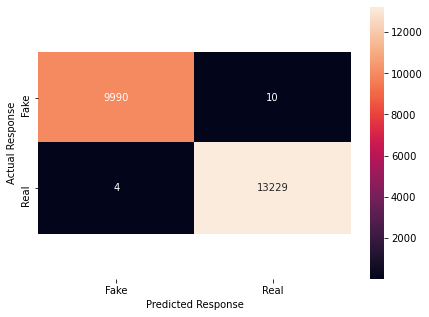

,model
accuracy_test,0.999
f1_test,0.999
precision_test,0.999
recall_test,1.000
True Fake,9990.000
True Real,13229.000
False Fake,4.000
False Real,10.000


Evaluate on test data
182/182 [==============================] - 513s 3s/step - loss: 0.0016 - accuracy: 0.9994
test loss, test acc: [0.0016265128506347537, 0.9993973970413208]
Classification Report
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     10000
        Real       1.00      1.00      1.00     13233

    accuracy                           1.00     23233
   macro avg       1.00      1.00      1.00     23233
weighted avg       1.00      1.00      1.00     23233



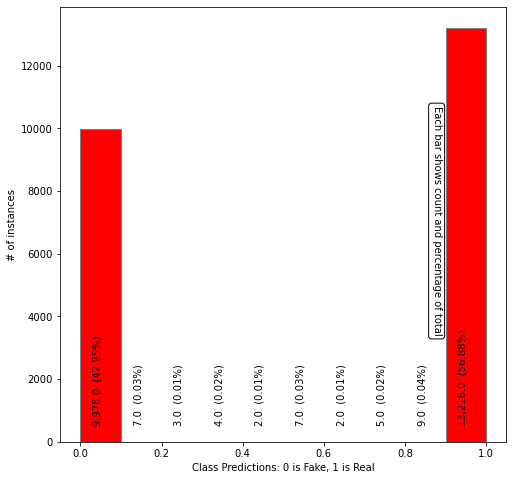

2 layer model
Count of data
23233


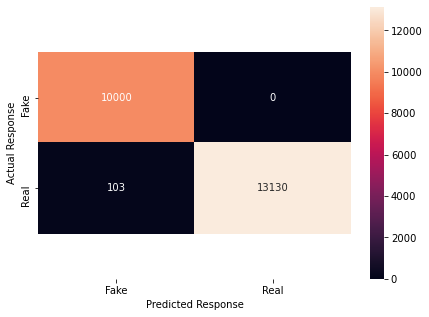

,model
accuracy_test,0.996
f1_test,0.996
precision_test,1.000
recall_test,0.992
True Fake,10000.000
True Real,13130.000
False Fake,103.000
False Real,0.000


Evaluate on test data
182/182 [==============================] - 471s 3s/step - loss: 0.0150 - accuracy: 0.9956
test loss, test acc: [0.015022044070065022, 0.9955666661262512]
Classification Report
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99     10000
        Real       1.00      0.99      1.00     13233

    accuracy                           1.00     23233
   macro avg       0.99      1.00      1.00     23233
weighted avg       1.00      1.00      1.00     23233



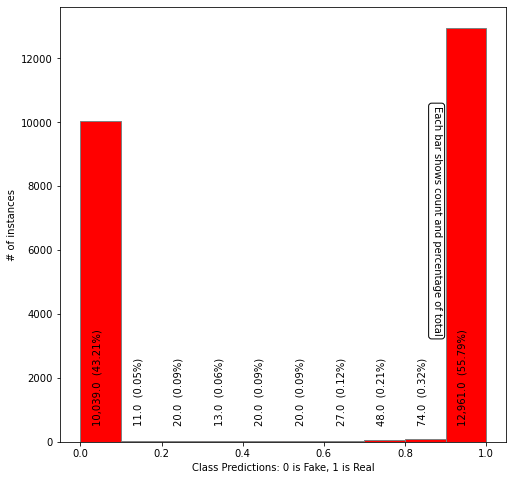

1 layer model
Count of data
23233


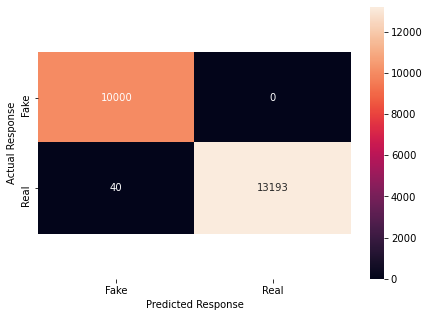

,model
accuracy_test,0.998
f1_test,0.998
precision_test,1.000
recall_test,0.997
True Fake,10000.000
True Real,13193.000
False Fake,40.000
False Real,0.000


Evaluate on test data
182/182 [==============================] - 404s 2s/step - loss: 0.0066 - accuracy: 0.9983
test loss, test acc: [0.006614708341658115, 0.9982783198356628]
Classification Report
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     10000
        Real       1.00      1.00      1.00     13233

    accuracy                           1.00     23233
   macro avg       1.00      1.00      1.00     23233
weighted avg       1.00      1.00      1.00     23233



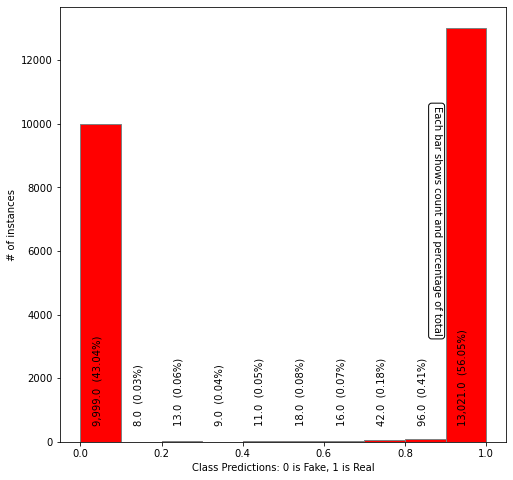

In [50]:
data_path = "data/validation_lfw"

test_all_models(data_path)

Found 2041 images belonging to 2 classes.
3 layer model
Count of data
2041


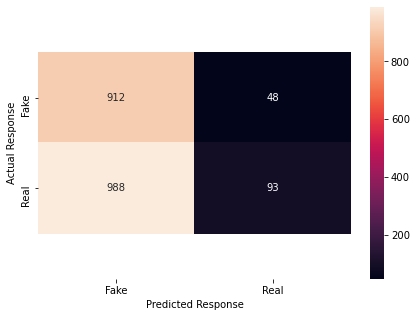

,model
accuracy_test,0.492
f1_test,0.152
precision_test,0.660
recall_test,0.086
True Fake,912.000
True Real,93.000
False Fake,988.000
False Real,48.000


Evaluate on test data
16/16 [==============================] - 48s 3s/step - loss: 4.7229 - accuracy: 0.4924
test loss, test acc: [4.722873687744141, 0.4924056828022003]
Classification Report
              precision    recall  f1-score   support

        Fake       0.48      0.95      0.64       960
        Real       0.66      0.09      0.15      1081

    accuracy                           0.49      2041
   macro avg       0.57      0.52      0.39      2041
weighted avg       0.58      0.49      0.38      2041



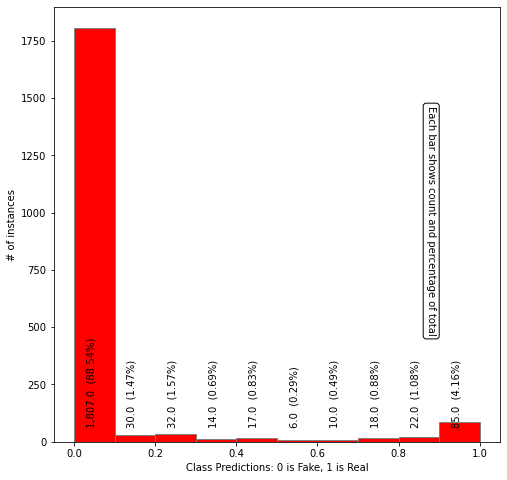

2 layer model
Count of data
2041


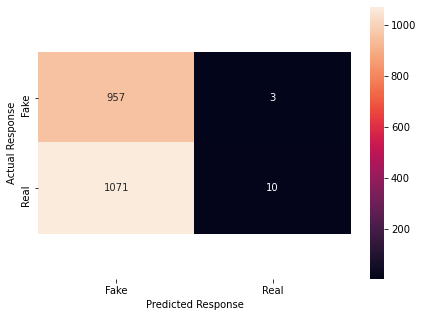

,model
accuracy_test,0.474
f1_test,0.018
precision_test,0.769
recall_test,0.009
True Fake,957.000
True Real,10.000
False Fake,1071.000
False Real,3.000


Evaluate on test data
16/16 [==============================] - 47s 3s/step - loss: 7.7999 - accuracy: 0.4738
test loss, test acc: [7.799867630004883, 0.4737873673439026]
Classification Report
              precision    recall  f1-score   support

        Fake       0.47      1.00      0.64       960
        Real       0.77      0.01      0.02      1081

    accuracy                           0.47      2041
   macro avg       0.62      0.50      0.33      2041
weighted avg       0.63      0.47      0.31      2041



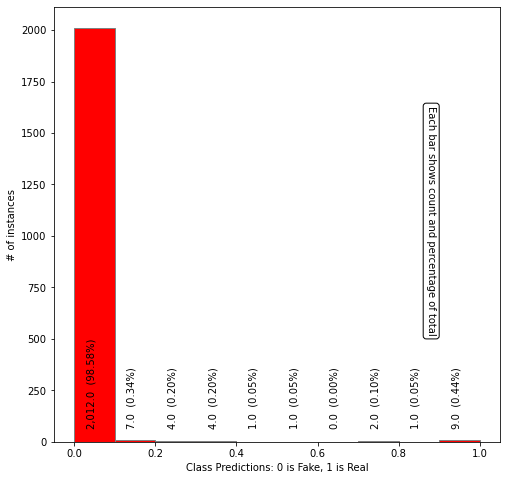

1 layer model
Count of data
2041


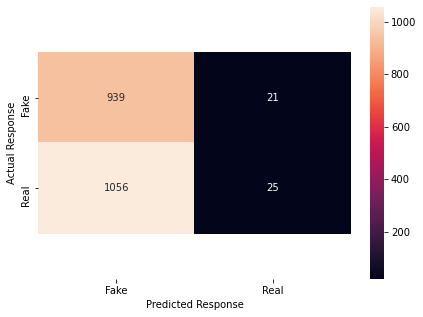

,model
accuracy_test,0.472
f1_test,0.044
precision_test,0.543
recall_test,0.023
True Fake,939.000
True Real,25.000
False Fake,1056.000
False Real,21.000


Evaluate on test data
16/16 [==============================] - 41s 3s/step - loss: 5.0620 - accuracy: 0.4723
test loss, test acc: [5.062041759490967, 0.47231748700141907]
Classification Report
              precision    recall  f1-score   support

        Fake       0.47      0.98      0.64       960
        Real       0.54      0.02      0.04      1081

    accuracy                           0.47      2041
   macro avg       0.51      0.50      0.34      2041
weighted avg       0.51      0.47      0.32      2041



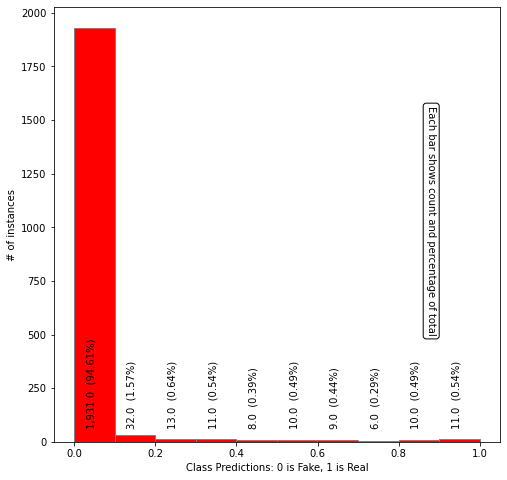

In [51]:
data_path = "data/validation_real_and_fake_face_kaggle"

test_all_models(data_path)

Found 7638 images belonging to 2 classes.
3 layer model
Count of data
7638


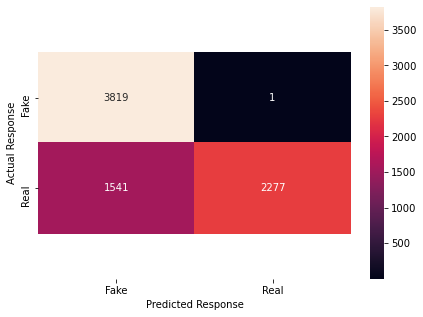

,model
accuracy_test,0.798
f1_test,0.747
precision_test,1.000
recall_test,0.596
True Fake,3819.000
True Real,2277.000
False Fake,1541.000
False Real,1.000


Evaluate on test data
60/60 [==============================] - 204s 3s/step - loss: 1.2261 - accuracy: 0.7981
test loss, test acc: [1.2260936498641968, 0.7981147170066833]
Classification Report
              precision    recall  f1-score   support

        Fake       0.71      1.00      0.83      3820
        Real       1.00      0.60      0.75      3818

    accuracy                           0.80      7638
   macro avg       0.86      0.80      0.79      7638
weighted avg       0.86      0.80      0.79      7638



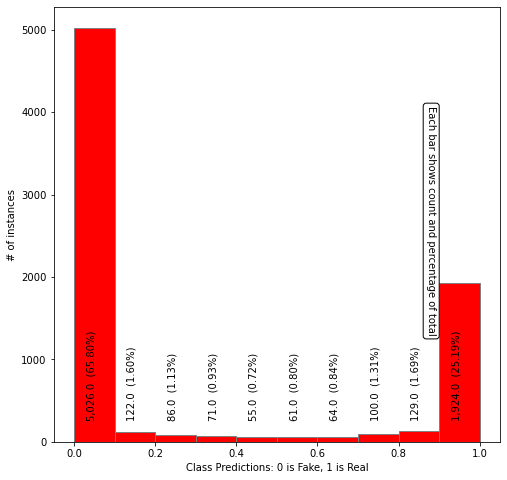

2 layer model
Count of data
7638


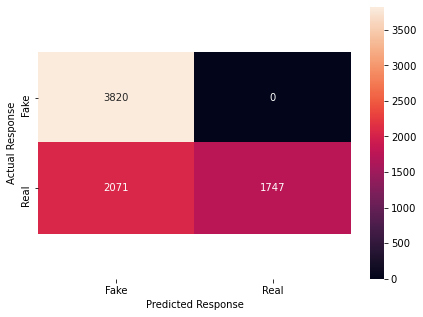

,model
accuracy_test,0.729
f1_test,0.628
precision_test,1.000
recall_test,0.458
True Fake,3820.000
True Real,1747.000
False Fake,2071.000
False Real,0.000


Evaluate on test data
60/60 [==============================] - 162s 3s/step - loss: 2.0112 - accuracy: 0.7289
test loss, test acc: [2.0112462043762207, 0.7288557291030884]
Classification Report
              precision    recall  f1-score   support

        Fake       0.65      1.00      0.79      3820
        Real       1.00      0.46      0.63      3818

    accuracy                           0.73      7638
   macro avg       0.82      0.73      0.71      7638
weighted avg       0.82      0.73      0.71      7638



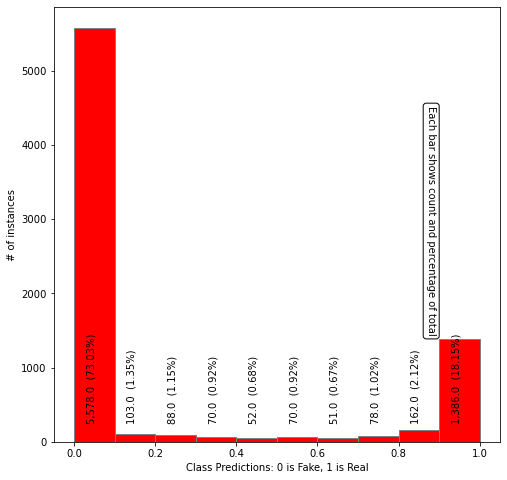

1 layer model
Count of data
7638


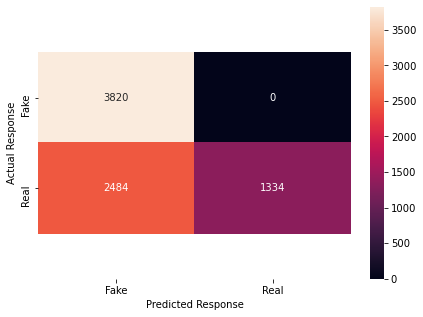

,model
accuracy_test,0.675
f1_test,0.518
precision_test,1.000
recall_test,0.349
True Fake,3820.000
True Real,1334.000
False Fake,2484.000
False Real,0.000


Evaluate on test data
60/60 [==============================] - 140s 2s/step - loss: 1.5118 - accuracy: 0.6748
test loss, test acc: [1.5117567777633667, 0.6747839450836182]
Classification Report
              precision    recall  f1-score   support

        Fake       0.61      1.00      0.75      3820
        Real       1.00      0.35      0.52      3818

    accuracy                           0.67      7638
   macro avg       0.80      0.67      0.64      7638
weighted avg       0.80      0.67      0.64      7638



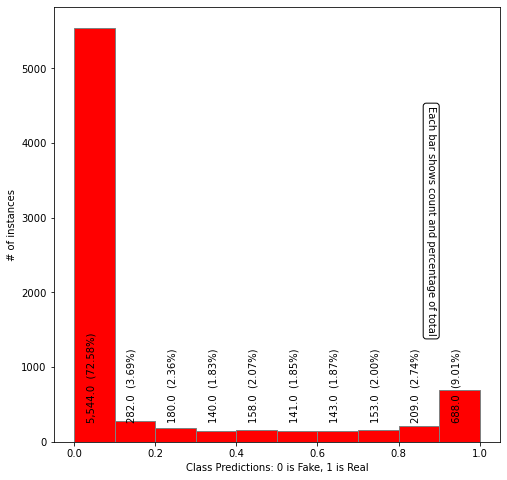

In [52]:
data_path = "data/validation_Large_Age_Gap"

test_all_models(data_path)

Found 43708 images belonging to 2 classes.
3 layer model
Count of data
43708


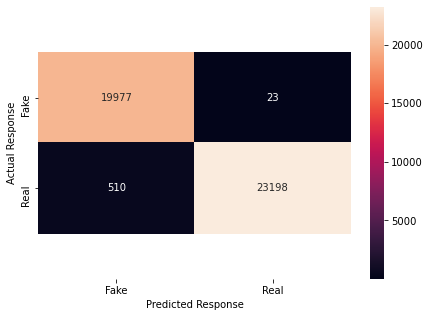

,model
accuracy_test,0.988
f1_test,0.989
precision_test,0.999
recall_test,0.978
True Fake,19977.000
True Real,23198.000
False Fake,510.000
False Real,23.000


Evaluate on test data
342/342 [==============================] - 1060s 3s/step - loss: 0.0371 - accuracy: 0.9878
test loss, test acc: [0.037130966782569885, 0.9878054261207581]
Classification Report
              precision    recall  f1-score   support

        Fake       0.98      1.00      0.99     20000
        Real       1.00      0.98      0.99     23708

    accuracy                           0.99     43708
   macro avg       0.99      0.99      0.99     43708
weighted avg       0.99      0.99      0.99     43708



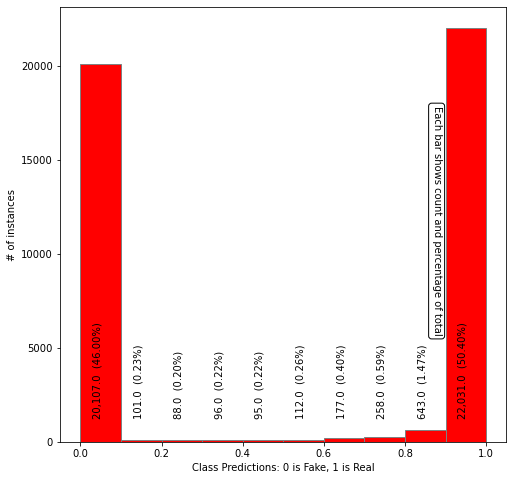

2 layer model
Count of data
43708


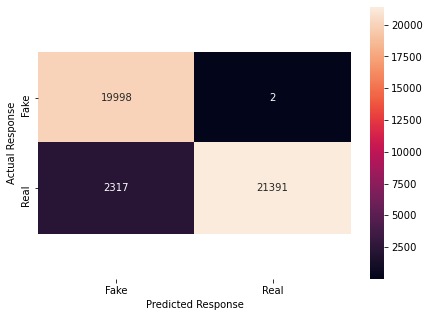

,model
accuracy_test,0.947
f1_test,0.949
precision_test,1.000
recall_test,0.902
True Fake,19998.000
True Real,21391.000
False Fake,2317.000
False Real,2.000


Evaluate on test data
342/342 [==============================] - 883s 3s/step - loss: 0.1680 - accuracy: 0.9469
test loss, test acc: [0.167984738945961, 0.9469433426856995]
Classification Report
              precision    recall  f1-score   support

        Fake       0.90      1.00      0.95     20000
        Real       1.00      0.90      0.95     23708

    accuracy                           0.95     43708
   macro avg       0.95      0.95      0.95     43708
weighted avg       0.95      0.95      0.95     43708



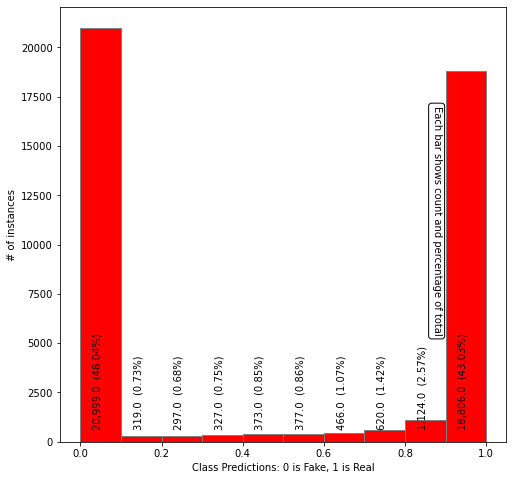

1 layer model
Count of data
43708


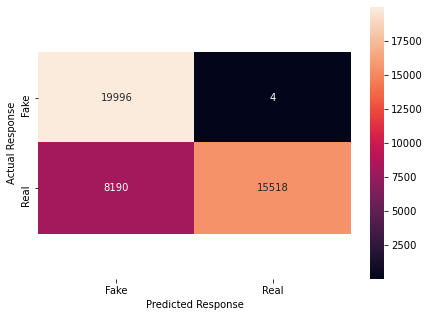

,model
accuracy_test,0.813
f1_test,0.791
precision_test,1.000
recall_test,0.655
True Fake,19996.000
True Real,15518.000
False Fake,8190.000
False Real,4.000


Evaluate on test data
342/342 [==============================] - 755s 2s/step - loss: 0.3962 - accuracy: 0.8125
test loss, test acc: [0.396236777305603, 0.8125286102294922]
Classification Report
              precision    recall  f1-score   support

        Fake       0.71      1.00      0.83     20000
        Real       1.00      0.65      0.79     23708

    accuracy                           0.81     43708
   macro avg       0.85      0.83      0.81     43708
weighted avg       0.87      0.81      0.81     43708



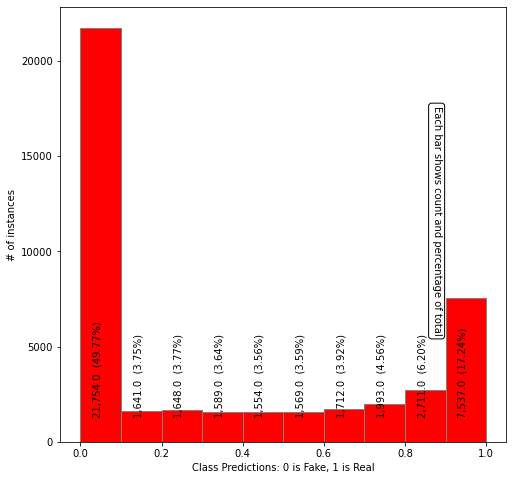

In [14]:
data_path = "data/validation_UKTFaces"

test_all_models(data_path)

Found 40258 images belonging to 2 classes.
3 layer model
Count of data
40258


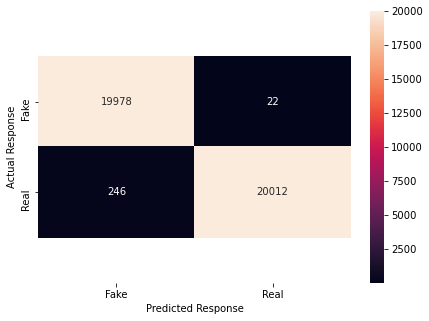

,model
accuracy_test,0.993
f1_test,0.993
precision_test,0.999
recall_test,0.988
True Fake,19978.000
True Real,20012.000
False Fake,246.000
False Real,22.000


Evaluate on test data
315/315 [==============================] - 935s 3s/step - loss: 0.0198 - accuracy: 0.9933
test loss, test acc: [0.019779233261942863, 0.993342936038971]
Classification Report
              precision    recall  f1-score   support

        Fake       0.99      1.00      0.99     20000
        Real       1.00      0.99      0.99     20258

    accuracy                           0.99     40258
   macro avg       0.99      0.99      0.99     40258
weighted avg       0.99      0.99      0.99     40258



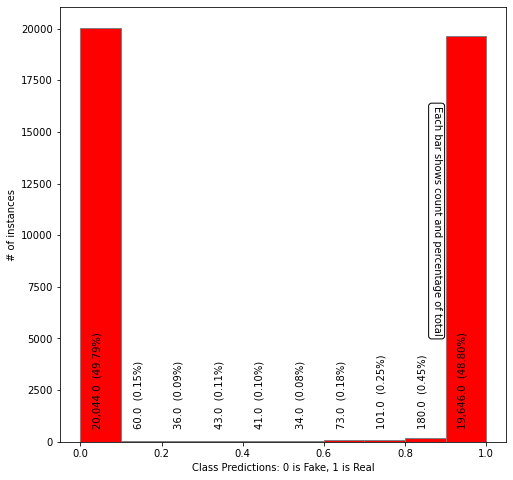

2 layer model
Count of data
40258


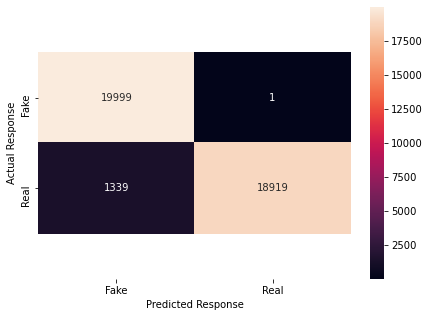

,model
accuracy_test,0.967
f1_test,0.966
precision_test,1.000
recall_test,0.934
True Fake,19999.000
True Real,18919.000
False Fake,1339.000
False Real,1.000


Evaluate on test data
315/315 [==============================] - 836s 3s/step - loss: 0.1126 - accuracy: 0.9667
test loss, test acc: [0.11263420432806015, 0.9667146801948547]
Classification Report
              precision    recall  f1-score   support

        Fake       0.94      1.00      0.97     20000
        Real       1.00      0.93      0.97     20258

    accuracy                           0.97     40258
   macro avg       0.97      0.97      0.97     40258
weighted avg       0.97      0.97      0.97     40258



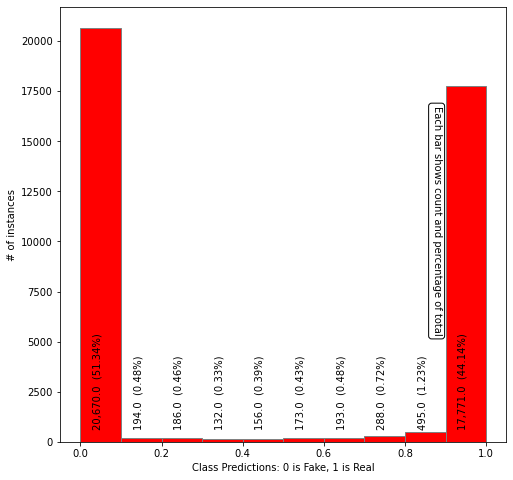

1 layer model
Count of data
40258


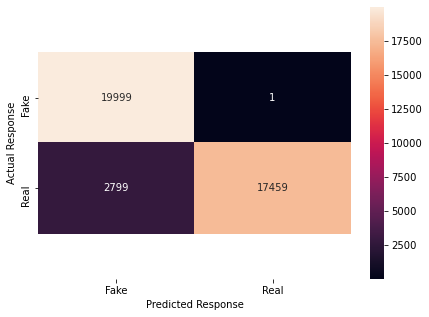

,model
accuracy_test,0.930
f1_test,0.926
precision_test,1.000
recall_test,0.862
True Fake,19999.000
True Real,17459.000
False Fake,2799.000
False Real,1.000


Evaluate on test data
315/315 [==============================] - 835s 3s/step - loss: 0.2082 - accuracy: 0.9304
test loss, test acc: [0.20818744599819183, 0.930448591709137]
Classification Report
              precision    recall  f1-score   support

        Fake       0.88      1.00      0.93     20000
        Real       1.00      0.86      0.93     20258

    accuracy                           0.93     40258
   macro avg       0.94      0.93      0.93     40258
weighted avg       0.94      0.93      0.93     40258



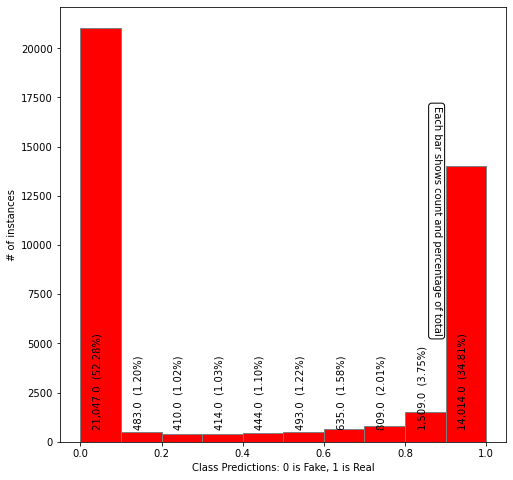

In [10]:
data_path = "data/test"

test_all_models(data_path)

Found 40000 images belonging to 2 classes.
3 layer model
Count of data
40000


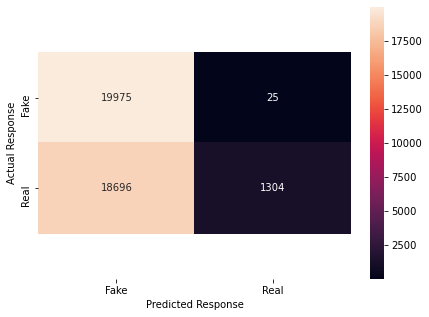

,model
accuracy_test,0.532
f1_test,0.122
precision_test,0.981
recall_test,0.065
True Fake,19975.000
True Real,1304.000
False Fake,18696.000
False Real,25.000


Evaluate on test data
313/313 [==============================] - 942s 3s/step - loss: 3.6664 - accuracy: 0.5320
test loss, test acc: [3.66644287109375, 0.5319749712944031]
Classification Report
              precision    recall  f1-score   support

        Fake       0.52      1.00      0.68     20000
        Real       0.98      0.07      0.12     20000

    accuracy                           0.53     40000
   macro avg       0.75      0.53      0.40     40000
weighted avg       0.75      0.53      0.40     40000



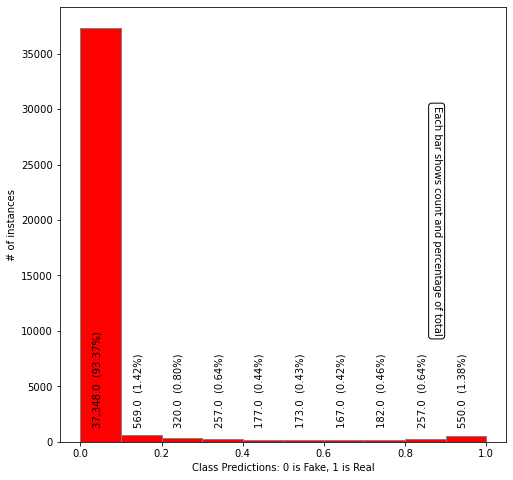

2 layer model
Count of data
40000


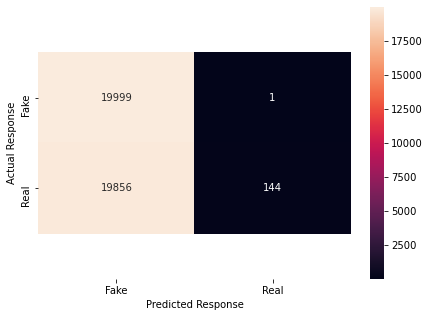

,model
accuracy_test,0.504
f1_test,0.014
precision_test,0.993
recall_test,0.007
True Fake,19999.000
True Real,144.000
False Fake,19856.000
False Real,1.000


Evaluate on test data
313/313 [==============================] - 834s 3s/step - loss: 5.8242 - accuracy: 0.5036
test loss, test acc: [5.824234485626221, 0.5035750269889832]
Classification Report
              precision    recall  f1-score   support

        Fake       0.50      1.00      0.67     20000
        Real       0.99      0.01      0.01     20000

    accuracy                           0.50     40000
   macro avg       0.75      0.50      0.34     40000
weighted avg       0.75      0.50      0.34     40000



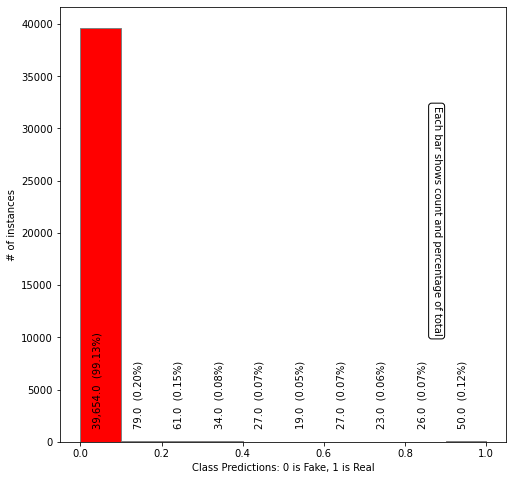

1 layer model
Count of data
40000


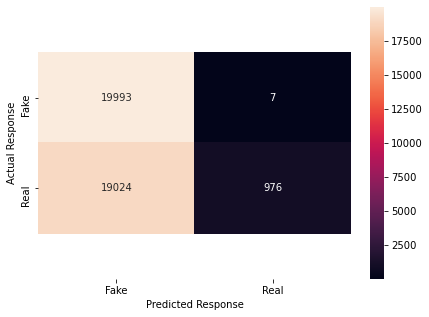

,model
accuracy_test,0.524
f1_test,0.093
precision_test,0.993
recall_test,0.049
True Fake,19993.000
True Real,976.000
False Fake,19024.000
False Real,7.000


Evaluate on test data
313/313 [==============================] - 626s 2s/step - loss: 2.6824 - accuracy: 0.5242
test loss, test acc: [2.682373285293579, 0.5242249965667725]
Classification Report
              precision    recall  f1-score   support

        Fake       0.51      1.00      0.68     20000
        Real       0.99      0.05      0.09     20000

    accuracy                           0.52     40000
   macro avg       0.75      0.52      0.39     40000
weighted avg       0.75      0.52      0.39     40000



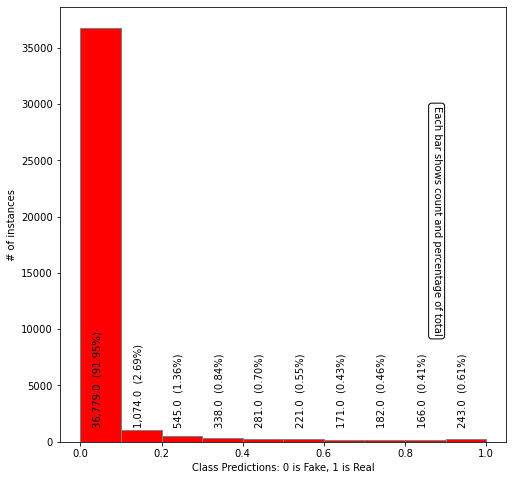

In [15]:
data_path = "data/validation_Flickr_Faces_HQ"

test_all_models(data_path)

Found 10000 images belonging to 2 classes.
3 layer model
Count of data
10000


/home/matthew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


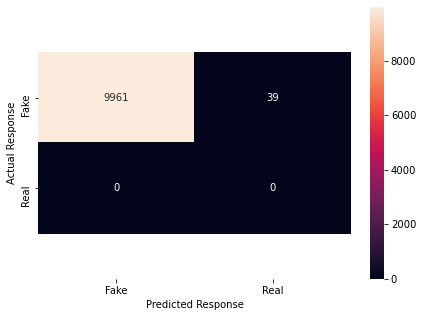

,model
accuracy_test,0.996
f1_test,0.000
precision_test,0.000
recall_test,0.000
True Fake,9961.000
True Real,0.000
False Fake,0.000
False Real,39.000


Evaluate on test data
79/79 [==============================] - 171s 2s/step - loss: 0.0121 - accuracy: 0.9961
test loss, test acc: [0.012052120640873909, 0.9961000084877014]
Classification Report
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     10000
        Real       0.00      0.00      0.00         0

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



/home/matthew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


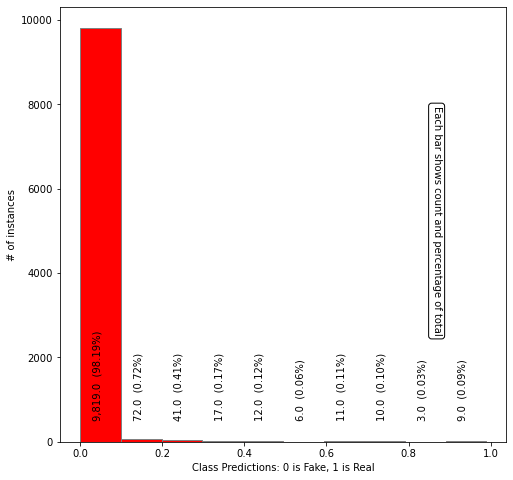

2 layer model
Count of data
10000


/home/matthew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


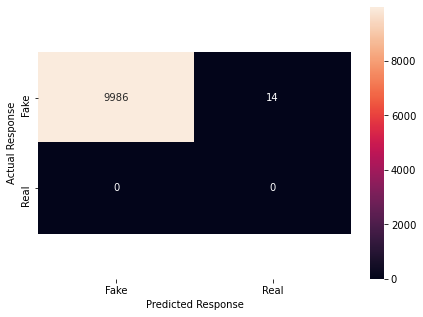

,model
accuracy_test,0.999
f1_test,0.000
precision_test,0.000
recall_test,0.000
True Fake,9986.000
True Real,0.000
False Fake,0.000
False Real,14.000


Evaluate on test data
79/79 [==============================] - 136s 2s/step - loss: 0.0053 - accuracy: 0.9986
test loss, test acc: [0.005309053231030703, 0.9986000061035156]
Classification Report
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     10000
        Real       0.00      0.00      0.00         0

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



/home/matthew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


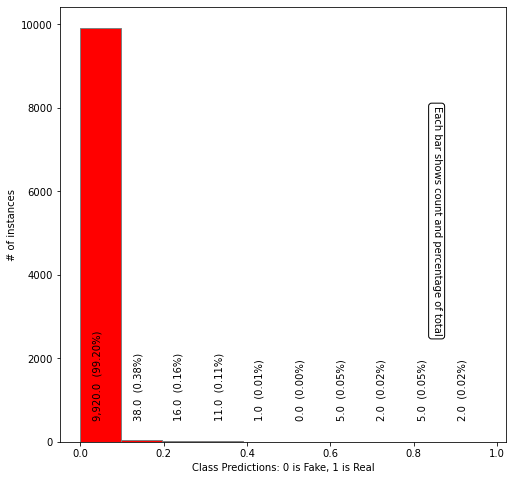

1 layer model
Count of data
10000


/home/matthew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


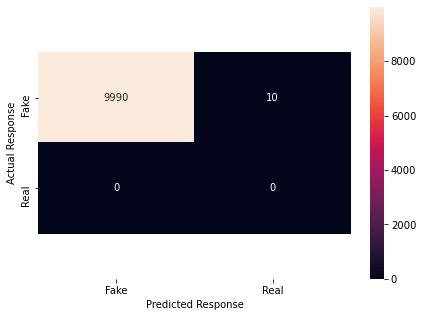

,model
accuracy_test,0.999
f1_test,0.000
precision_test,0.000
recall_test,0.000
True Fake,9990.000
True Real,0.000
False Fake,0.000
False Real,10.000


Evaluate on test data
79/79 [==============================] - 103s 1s/step - loss: 0.0136 - accuracy: 0.9990
test loss, test acc: [0.013579053804278374, 0.9990000128746033]
Classification Report
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00     10000
        Real       0.00      0.00      0.00         0

    accuracy                           1.00     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       1.00      1.00      1.00     10000



/home/matthew/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


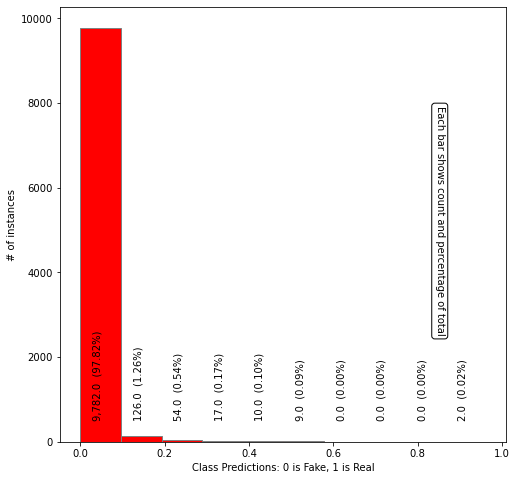

In [11]:
data_path = "data/validation_generated_images/validation_use"

test_all_models(data_path)

Found 2000 images belonging to 2 classes.
3 layer model
Count of data
2000


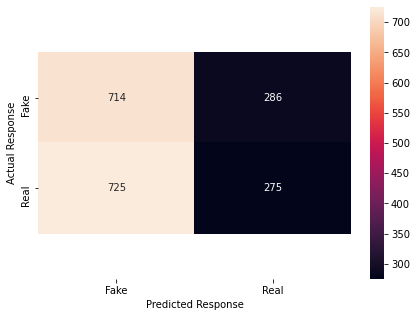

,model
accuracy_test,0.494
f1_test,0.352
precision_test,0.490
recall_test,0.275
True Fake,714.000
True Real,275.000
False Fake,725.000
False Real,286.000


Evaluate on test data
16/16 [==============================] - 119s 7s/step - loss: 3.0363 - accuracy: 0.4945
test loss, test acc: [3.036306381225586, 0.4945000112056732]
Classification Report
              precision    recall  f1-score   support

        Fake       0.50      0.71      0.59      1000
        Real       0.49      0.28      0.35      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.47      2000
weighted avg       0.49      0.49      0.47      2000



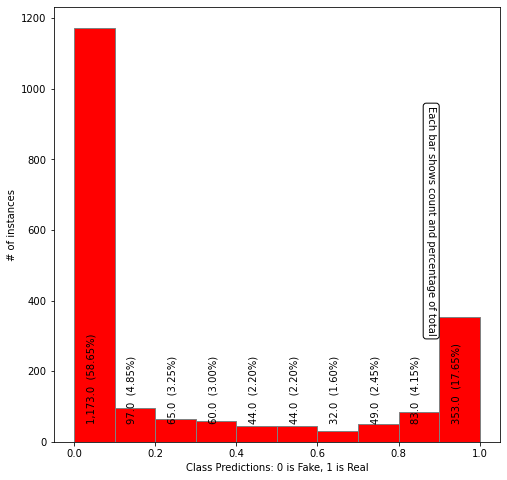

2 layer model
Count of data
2000


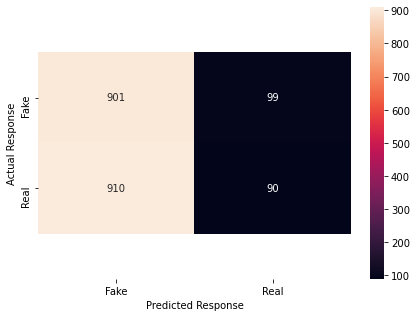

,model
accuracy_test,0.496
f1_test,0.151
precision_test,0.476
recall_test,0.090
True Fake,901.000
True Real,90.000
False Fake,910.000
False Real,99.000


Evaluate on test data
16/16 [==============================] - 119s 7s/step - loss: 4.9714 - accuracy: 0.4955
test loss, test acc: [4.97135066986084, 0.49549999833106995]
Classification Report
              precision    recall  f1-score   support

        Fake       0.50      0.90      0.64      1000
        Real       0.48      0.09      0.15      1000

    accuracy                           0.50      2000
   macro avg       0.49      0.50      0.40      2000
weighted avg       0.49      0.50      0.40      2000



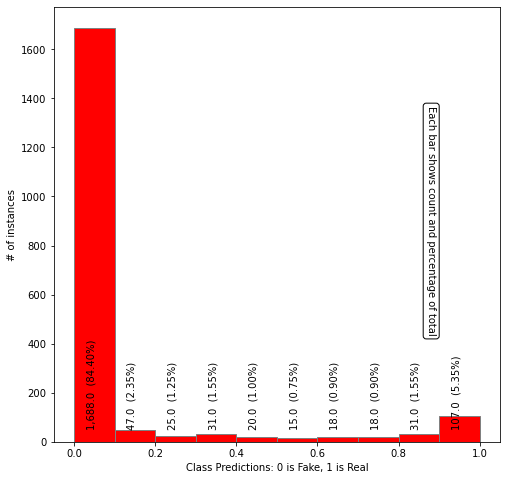

1 layer model
Count of data
2000


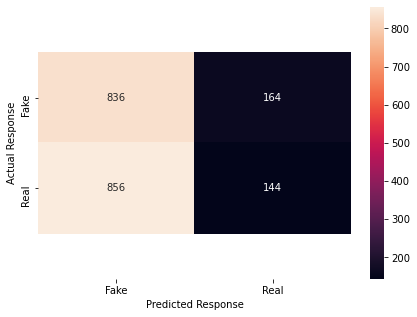

,model
accuracy_test,0.490
f1_test,0.220
precision_test,0.468
recall_test,0.144
True Fake,836.000
True Real,144.000
False Fake,856.000
False Real,164.000


Evaluate on test data
16/16 [==============================] - 110s 7s/step - loss: 3.2483 - accuracy: 0.4900
test loss, test acc: [3.2482995986938477, 0.49000000953674316]
Classification Report
              precision    recall  f1-score   support

        Fake       0.49      0.84      0.62      1000
        Real       0.47      0.14      0.22      1000

    accuracy                           0.49      2000
   macro avg       0.48      0.49      0.42      2000
weighted avg       0.48      0.49      0.42      2000



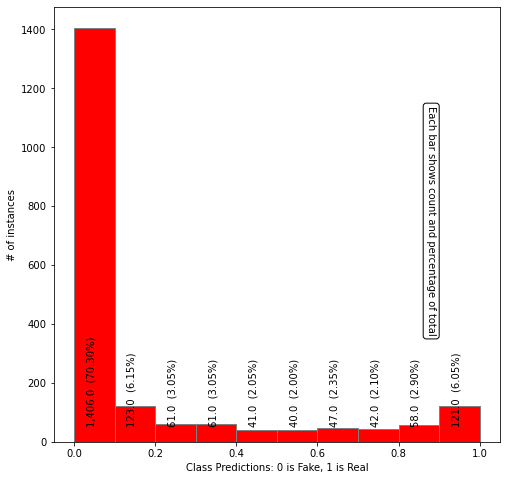

In [16]:
data_path = "data/validation_photoshop_dataset/photoshop_validation"

test_all_models(data_path)